In [1]:
import env
import pandas as pd
import requests as req
import acquire
import matplotlib.pyplot as plt
import seaborn as sns
import prepare

from io import StringIO

# Acquisition Exercises

1. Using the code from the lesson as a guide and the REST API from https://python.zach.lol/api/v1/items as we did in the lesson, create a dataframe named items that has all of the data for items.

In [ ]:
endpoint = "https://python.zach.lol/api/v1/items"

In [ ]:
response = req.get(endpoint)

In [ ]:
response = response.json()

In [ ]:
payload = response['payload']
payload

In [ ]:
n = payload['max_page']

In [ ]:
item_list = []
url = "https://python.zach.lol/api/v1/items"

for i in range(1, n+1):
    new_url = url + "?page=" + str(i)
    response = req.get(new_url)
    data = response.json()
    page_items = data['payload']['items']
    item_list += page_items
    
item_list

In [ ]:
items_df = pd.DataFrame(item_list)

In [ ]:
items_df

In [ ]:
def create_df_from_payloads(endpoint, max_pages, target_key_name):
    page_list = []
    
    for i in range(1, max_pages + 1):
        response = req.get(endpoint + "?page=" + str(i))
        data = response.json()
        page_items = data['payload'][target_key_name]
        page_list += page_items
        
    return pd.DataFrame(page_list)

In [ ]:
test_df = create_df_from_payloads("https://python.zach.lol/api/v1/items", 3, 'items')
test_df.shape

2. Do the same thing, but for stores (https://python.zach.lol/api/v1/stores)

In [ ]:
response = req.get("https://python.zach.lol/api/v1/stores")
response = response.json()

In [ ]:
stores_df = create_df_from_payloads("https://python.zach.lol/api/v1/stores", 1, 'stores')

In [ ]:
stores_df

3. Extract the data for sales (https://python.zach.lol/api/v1/sales). There are a lot of pages of data here, so your code will need to be a little more complex. Your code should continue fetching data from the next page until all of the data is extracted.

In [ ]:
response columnsget("https://python.zach.lol/api/v1/sales")
response = response.json()

max_pages = response['payload']['max_page']

In [ ]:
sales_df = create_df_from_payloads("https://python.zach.lol/api/v1/sales", max_pages, 'sales')
sales_df

4. Save the data in your files to local csv files so that it will be faster to access in the future.

In [ ]:
sales_df.to_csv("sales.csv", index=False)
stores_df.to_csv("stores.csv", index=False)
items_df.to_csv("items.csv", index=False)

5. Combine the data from your three separate dataframes into one large dataframe.

In [ ]:
items_df.columns

In [ ]:
stores_df.columns

In [ ]:
sales_df.columns

In [ ]:
sales_df.rename(columns={'item' : 'item_id'}, inplace=True)
merged_df = pd.merge(items_df, sales_df, how="left", on="item_id")

merged_df.rename(columns={'store' : 'store_id'}, inplace=True)
merged_df = pd.merge(merged_df, stores_df, how="left", on="store_id")

merged_df.columns

6. Acquire the Open Power Systems Data for Germany, which has been rapidly expanding its renewable energy production in recent years. The data set includes country-wide totals of electricity consumption, wind power production, and solar power production for 2006-2017. You can get the data here: https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv

In [ ]:
response = req.get("https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv")

csv = StringIO(response.text)

germany_df = pd.read_csv(csv)

In [ ]:
germany_df

In [ ]:
items_df = acquire.acquire_df_from_zach_api("https://python.zach.lol/api/v1/items", 'items')
items_df.shape

In [ ]:
stores_df = acquire.acquire_df_from_zach_api("https://python.zach.lol/api/v1/stores", 'stores')
stores_df.shape

In [ ]:
sales_df = pd.read_csv("sales.csv")
sales_df.shape

In [ ]:
final_df = acquire.merge_zach_dataframes(items_df, stores_df, sales_df)
final_df.shape

In [ ]:
germany_df = acquire.acquire_germany()
germany_df.shape

# Working with time series data exercises

* Use the above dataset for the exercises below:

In [ ]:
from vega_datasets import data
data.sf_temps()

1. Resample by the day and take the average temperature. Visualize the average temperature over time.

In [ ]:
temps_df = data.sf_temps()
temps_df['date'] = pd.to_datetime(temps_df['date'])
temps_df.dtypes

In [ ]:
temps_df = temps_df.set_index('date').sort_index()

In [ ]:
daily_mean_temps_df = temps_df.resample('D').mean()

In [ ]:
sns.scatterplot(x=daily_mean_temps_df.index, y=daily_mean_temps_df.temp)
plt.show()

2. Write the code necessary to visualize the minimum temperature over time.

In [ ]:
daily_max_temps = temps_df.resample('D').max()

sns.scatterplot(x=daily_max_temps.index, y=daily_max_temps.temp)
plt.show()

3. Write the code necessary to visualize the maximum tempberature over time.

In [ ]:
daily_min_temps = temps_df.resample('D').min()

sns.scatterplot(x=daily_min_temps.index, y=daily_min_temps.temp)
plt.show()

4. Which month is the coldest, on average?

In [ ]:
monthly_temps = temps_df.resample('M').mean()
monthly_temps.nsmallest(1, 'temp')

5. Which month has the highest average temperature?

In [ ]:
monthly_temps.nlargest(1, 'temp')

6. Resample by the day and calculate the min and max temp for the day (Hint: .agg(['min', 'max'])). Use this resampled dataframe to calculate the change in temperature for the day. Which month has the highest daily temperature variability?

In [ ]:
daily_temps = temps_df.resample('D').agg(['min', 'max'])

In [ ]:
daily_temps = daily_temps.droplevel(0, axis=1)

In [ ]:
daily_temps['temp_change'] = daily_temps['max'] - daily_temps['min']

In [ ]:
daily_temps.nlargest(1, 'temp_change')

In [ ]:
monthly_variability = daily_temps.temp_change.resample('M').max()
monthly_variability.nlargest(1)

7. Bonus: Visualize the daily min, average, and max temperature over time on a single line plot, i.e. the min, average, and maximum temperature should be 3 seperate lines.

In [ ]:
daily_temps = temps_df.resample('D').agg(['min', 'mean', 'max'])
daily_temps

In [ ]:
daily_temps = daily_temps.droplevel(0, axis=1)

In [ ]:
daily_temps.sample(14)

In [ ]:
plt.plot(daily_temps.index, daily_temps['min'], label="min_temp")
plt.plot(daily_temps.index, daily_temps['mean'], label="average_temp")
plt.plot(daily_temps.index, daily_temps['max'], label="max_temp")
plt.legend()
plt.show()

In [ ]:
from vega_datasets import data
weather_df = data.seattle_weather()

* Use the dataset to answer the following questions:

1. Which year and month combination has the highest amount of precipitation?

In [ ]:
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df = weather_df.set_index('date').sort_index()

In [ ]:
monthly_weather = weather_df.resample('M').max()
monthly_weather.nlargest(1, 'precipitation')

2. Visualize the amount of monthly precipitation over time.

In [ ]:
plt.figure(figsize=(14,10))
sns.lineplot(x=monthly_weather.index, y=monthly_weather.precipitation)
plt.show()

3. Visualize the amount of wind over time. Choose a time interval you think is appropriate.

In [ ]:
quarterly_weather = weather_df.resample('Q').mean()

plt.figure(figsize=(14, 10))
sns.lineplot(x=quarterly_weather.index, y=quarterly_weather.wind)

4. Which year-month combination is the windiest?

In [ ]:
monthly_weather.nlargest(1, 'wind')

5. What's the sunniest year? (Hint: which day has the highest number of days where weather == sun?)

In [ ]:
weather_df['is_sunny'] = weather_df.weather.apply(lambda weather : 1 if weather == "sun" else 0)

In [ ]:
yearly_weather = weather_df.resample('A').sum()
yearly_weather.nlargest(1, 'is_sunny')                                              

6. In which month does it rain the most?

In [ ]:
monthly_mean_weather = weather_df.resample('M').mean()
monthly_mean_weather.nlargest(1, 'precipitation')

In [ ]:
monthly_mean_weather

In [ ]:
year_2012 = monthly_mean_weather.iloc[0: 12]
year_2012.shape

In [ ]:
year_2013 = monthly_mean_weather.iloc[12: 24]
year_2013.shape

In [ ]:
year_2014 = monthly_mean_weather.iloc[24: 36]
year_2014.shape

In [ ]:
year_2015 = monthly_mean_weather.iloc[36: 48]
year_2015.shape

In [ ]:
print(year_2012.precipitation.nlargest(1))
print(year_2013.precipitation.nlargest(1))
print(year_2014.precipitation.nlargest(1))
print(year_2015.precipitation.nlargest(1))

7. Which month has the most number of days with a non-zero amount of precipitation?

In [ ]:
weather_df['had_rain'] = weather_df.precipitation.apply(lambda rain : 1 if rain > 0 else 0)
weather_df

In [ ]:
monthly_rain = weather_df.resample('M').sum()
monthly_rain.had_rain.nlargest(1)

1. Convert any negative delays to 0.

In [ ]:
flights_df = data.flights_20k()

In [ ]:
flights_df.delay = flights_df.delay.apply(lambda delay : 0 if delay < 0 else delay)
flights_df[flights_df.delay < 0]

2. Which hour of the day has the highest average delay?

In [ ]:
flights_df = flights_df.set_index('date').sort_index()

In [ ]:
flights_df['hour_of_day'] = flights_df.index.hour
flights_df[flights_df.hour_of_day == 3]

In [ ]:
flights_df.groupby('hour_of_day').delay.mean().nlargest(1)

3. Does the day of the week make a difference in the delay amount?

In [ ]:
flights_df['day_of_week'] = flights_df.index.day_name()
flights_df.sample(5)

In [ ]:
flights_df.groupby('day_of_week').delay.mean()

4. Does the month make a difference in the delay amount?

In [ ]:
flights_df['month'] = flights_df.index.month_name()
flights_df.groupby('month').delay.mean()

In [ ]:
hourly_flights_df = flights_df.resample('H').mean()
hourly_flights_df = hourly_flights_df.dropna()

In [ ]:
hourly_flights_df['hour_of_day'] = hourly_flights_df.index.hour
hourly_flights_df.groupby('hour_of_day').delay.mean()

# Prepare Exercises

In [2]:
items_df = pd.read_csv("items.csv")
stores_df = pd.read_csv("stores.csv")
sales_df = pd.read_csv("sales.csv")

zach_df = acquire.merge_zach_dataframes(items_df, stores_df, sales_df)
zach_df.columns

Index(['item_brand', 'item_id', 'item_name', 'item_price', 'item_upc12',
       'item_upc14', 'sale_amount', 'sale_date', 'sale_id', 'store_id',
       'store_address', 'store_city', 'store_state', 'store_zipcode'],
      dtype='object')

1. Convert date column to datetime format.

3. Set the index to be the datetime variable.

In [ ]:
zach_df.sale_date = pd.to_datetime(zach_df.sale_date)
zach_df = zach_df.set_index('sale_date').sort_index()

In [ ]:
zach_df.index = zach_df.index.tz_localize(None)

2. Plot the distribution of sale_amount and item_price.

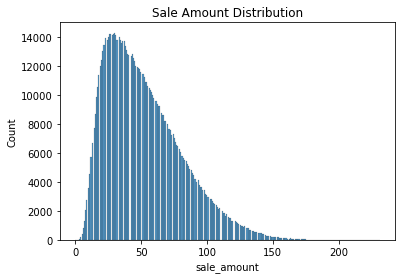

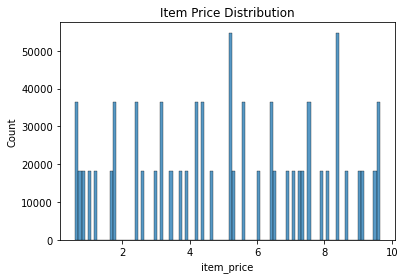

In [5]:
sns.histplot(zach_df.sale_amount)
plt.title("Sale Amount Distribution")
plt.show()

sns.histplot(zach_df.item_price)
plt.title("Item Price Distribution")
plt.show()

4. Add a 'month' and 'day of week' column to your dataframe.

In [ ]:
zach_df['month'] = zach_df.index.month_name()
zach_df['day_of_week'] = zach_df.index.day_name()
zach_df.sample(5)

5. Add a column to your dataframe, sales_total, which is a derived from sale_amount (total items) and item_price.

In [ ]:
zach_df['sales_total'] = zach_df.sale_amount * zach_df.item_price
zach_df.sample(5)

6. Make sure all the work that you have done above is reproducible. That is, you should put the code above into separate functions and be able to re-run the functions and get the same results.

In [3]:
zach_df = prepare.prepare_zach_df(zach_df)
zach_df.sample(5)

,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,sale_amount,sale_id,store_id,store_address,store_city,store_state,store_zipcode,month,day_of_week,sales_total
sale_date,,,,,,,,,,,,,,,,
2017-10-05,Sundown Naturals,38,Sundown Naturals Essential Electrolytes Tropic...,3.45,30768540548,30768540548,84.0,677359,1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,10,3,289.80
2017-04-30,Honest Tea,11,Honest Tea Peach White Tea,3.93,657622604842,657622604842,86.0,191485,5,1520 Austin Hwy,San Antonio,TX,78218,4,6,337.98
2014-02-27,Munchies,39,Munchies Sandwich Crackers Cheddar Cheese On G...,9.02,28400029254,28400029254,36.0,710737,10,8503 NW Military Hwy,San Antonio,TX,78231,2,3,324.72
2017-01-01,Mama Marys,46,Pizza Sauce,4.65,35457770664,35457770664,59.0,835944,8,15000 San Pedro Ave,San Antonio,TX,78232,1,6,274.35
2014-07-18,Usda Produce,20,Plums Black,5.62,204040000000,204040000000,50.0,356634,6,1015 S WW White Rd,San Antonio,TX,78220,7,4,281.00


In [4]:
zach_df.columns

Index(['item_brand', 'item_id', 'item_name', 'item_price', 'item_upc12',
       'item_upc14', 'sale_amount', 'sale_id', 'store_id', 'store_address',
       'store_city', 'store_state', 'store_zipcode', 'month', 'day_of_week',
       'sales_total'],
      dtype='object')

* Using the OPS data acquired in the Acquire exercises opsd_germany_daily.csv, complete the following:

In [2]:
germany_df = acquire.acquire_germany()

1. Convert date column to datetime format.

In [3]:
col_dict = {'Consumption' : 'consumption', 'Date' : 'date', 'Wind' : 'wind', 'Solar' : 'solar', 'Wind+Solar' : 'wind_and_solar'}
germany_df.rename(columns=col_dict, inplace=True)
germany_df.columns

Index(['date', 'consumption', 'wind', 'solar', 'wind_and_solar'], dtype='object')

2. Plot the distribution of each of your variables.

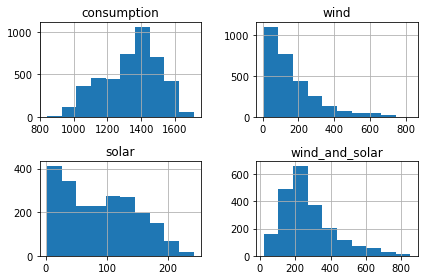

In [4]:
germany_df.hist(germany_df.columns)
plt.tight_layout()
plt.show()

3. Set the index to be the datetime variable.

In [ ]:
germany_df.date = pd.to_datetime(germany_df.date)

germany_df = germany_df.set_index('date').sort_index()

4. Add a month and a year column to your dataframe.

In [ ]:
germany_df['month'] = germany_df.index.month
germany_df['year'] = germany_df.index.year
germany_df

5. Fill any missing values.

In [ ]:
germany_df = germany_df.fillna(value=0)
germany_df

6. Make sure all the work that you have done above is reproducible. That is, you should put the code above into separate functions and be able to re-run the functions and get the same results.

In [5]:
germany_df = prepare.prepare_germany_df(germany_df)
germany_df.shape

(4383, 6)

In [6]:
germany_df.columns

Index(['consumption', 'wind', 'solar', 'wind_and_solar', 'month', 'year'], dtype='object')